### features:
* only statistical features domain

In [1]:
import pandas as pd 
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, recall_score
import matplotlib.pyplot as plt
import itertools

In [2]:
path =  "/Users/ecem/Desktop/phonocardiogram/data"

## Load data

In [3]:
features = pd.read_csv(path + "/mock-features.csv", index_col = 0)

In [4]:
features.head()

,petrosian f.a.,katz f.a.,higuchi f.a.,deterended fluctuations f.a.
0,1.002736,1.920990,1.091685,0.921825
1,1.002308,2.377508,1.052431,0.904970
2,1.002273,2.223252,1.046259,0.982775
3,1.002218,2.291023,1.048935,0.942318
4,1.002254,2.274571,1.046809,0.918872


## Load labels

In [5]:
labels = np.load(path + "/labels.npy", allow_pickle = True)

In [6]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(features, labels, train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [7]:
import xgboost as xgb
classifier = MultiOutputClassifier(xgb.XGBClassifier(objective = 'binary:logistic'))

clf = Pipeline([('classify', classifier)])


In [8]:
clf.fit(X_train_, y_train_)


Pipeline(steps=[('classify',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric=None,
                                                               gamma=None,
                                                               gpu_id=None,
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None,
                                                               reg_alpha=None,
                                                               reg_lambda=None, ...)))])

In [9]:
yhat = clf.predict(X_valid_)

In [10]:
df_results_test = pd.DataFrame({'AV': y_valid_[:,0], 'MV': y_valid_[:,1], 'PV': y_valid_[:,2], 'TV': y_valid_[:,3],
                        'predicted AV': yhat[:,0],
                          'predicted MV': yhat[:,1],
                          'predicted PV': yhat[:,2], 
                          'predicted TV': yhat[:,3]})
df_results_test

,AV,MV,PV,TV,predicted AV,predicted MV,predicted PV,predicted TV
0,0.0,0.0,0.0,1.0,0,1,0,0
1,0.0,0.0,1.0,0.0,0,0,0,0
2,0.0,1.0,0.0,0.0,0,0,0,0
3,0.0,0.0,1.0,0.0,0,0,0,0
4,0.0,1.0,0.0,0.0,0,0,1,0
...,...,...,...,...,...,...,...,...
941,1.0,0.0,0.0,0.0,0,0,0,0
942,0.0,0.0,1.0,0.0,0,0,1,0
943,0.0,1.0,0.0,0.0,0,1,0,0
944,1.0,0.0,0.0,0.0,0,0,1,0


In [11]:
auc_y1 = roc_auc_score(y_valid_[:,0],yhat[:,0])
auc_y2 = roc_auc_score(y_valid_[:,1],yhat[:,1])
auc_y3 = roc_auc_score(y_valid_[:,2],yhat[:,2])
auc_y4 = roc_auc_score(y_valid_[:,3],yhat[:,3])

print("ROC AUC AV: %.4f, MV: %.4f, PV: %.4f, TV: %.4f " % (auc_y1, auc_y2, auc_y3, auc_y4))


ROC AUC AV: 0.5817, MV: 0.5666, PV: 0.5724, TV: 0.6027 


In [12]:
weighted_roc_auc_ovo = roc_auc_score(
    y_valid_, yhat, multi_class="ovr", average="weighted"
)

In [13]:
weighted_roc_auc_ovo

0.5813808345765991

In [14]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_valid_[:, i], yhat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid_.ravel(), yhat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


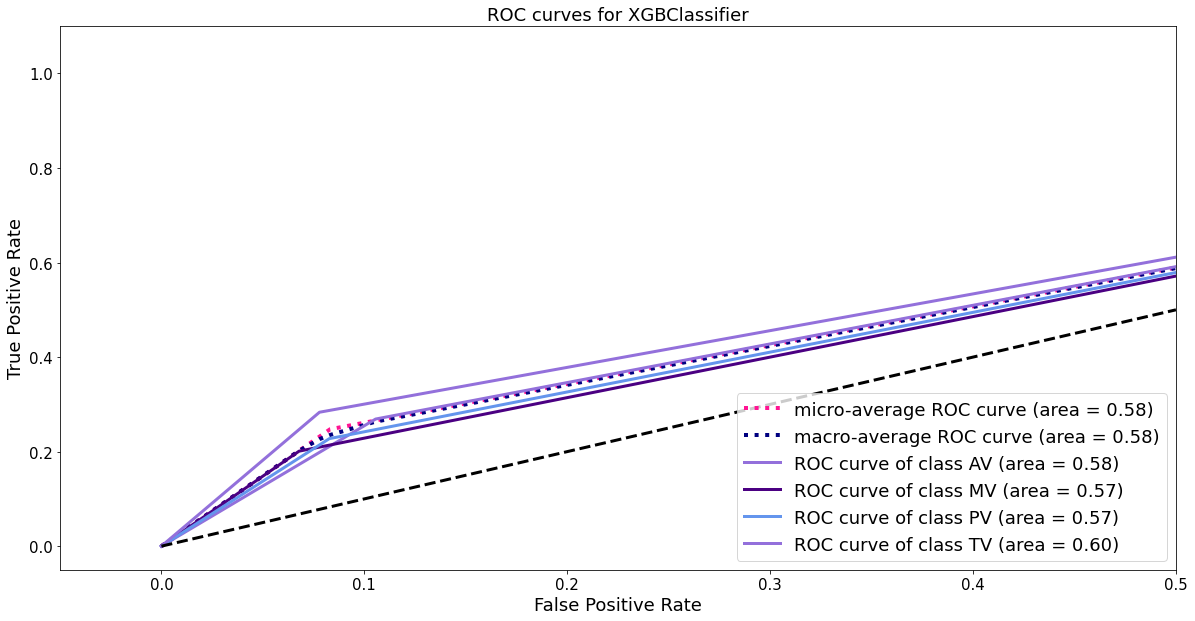

In [15]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_valid_[:, i], yhat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid_.ravel(), yhat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

n_classes = 4
class_names = ["AV", "MV", "PV", "TV"]

from itertools import cycle
lw =3

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 10))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["mediumpurple", "indigo", "cornflowerblue"])

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=3,
        label="ROC curve of class {0} (area = {1:0.2f})".format(class_names[i], roc_auc[i]),
    )

plt.plot([0.0, 0.5], [0.0, 0.5], "k--", lw=lw)
plt.xlim([-0.05, 0.5])
plt.xticks(fontsize=15)
plt.ylim([-0.05, 1.1])
plt.yticks(fontsize=15)
plt.xlabel("False Positive Rate",fontsize = 18 )
plt.ylabel("True Positive Rate", fontsize = 18)
plt.title("ROC curves for XGBClassifier",fontsize = 18)
plt.legend(loc="lower right", fontsize = 18) 
plt.show()

In [16]:
cm_y1 = confusion_matrix(y_valid_[:,0],yhat[:,0])
cm_y2 = confusion_matrix(y_valid_[:,1],yhat[:,1])
cm_y3 = confusion_matrix(y_valid_[:,2],yhat[:,2])
cm_y4 = confusion_matrix(y_valid_[:,3],yhat[:,3])
print(cm_y1)



[[610  72]
 [193  71]]


In [17]:
class_dict = {0:'AV', 1:'MV', 2:'PV', 3:'TV'}

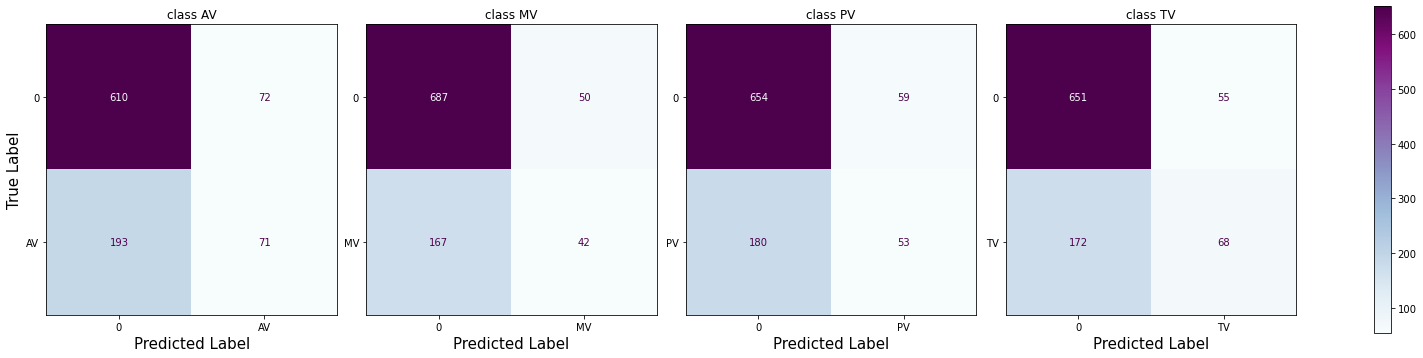

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

f, axes = plt.subplots(1, 4, figsize=(28, 15))
axes = axes.ravel()
for i in range(4):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_valid_[:, i],
                                                   yhat[:, i]),
                                  display_labels=[0, i])
    if i == 0:
        disp.plot(ax=axes[i], values_format='.4g' , cmap = 'BuPu')
        disp.ax_.set_title(f'class {class_names[i]}')
        disp.ax_.set_xlabel('Predicted Label', fontsize =15)
        disp.ax_.set_ylabel('True Label', fontsize = 15)
        disp.ax_.set_xticklabels([0,class_names[i]])
        disp.ax_.set_yticklabels([0,class_names[i]])
        disp.im_.colorbar.remove()
    else:
        disp.plot(ax=axes[i], values_format='.4g' , cmap = 'BuPu')
        disp.ax_.set_title(f'class {class_names[i]}')
        disp.ax_.set_xlabel('Predicted Label', fontsize =15)
        disp.ax_.set_ylabel(' ')
        disp.ax_.set_xticklabels([0,class_names[i]])
        disp.ax_.set_yticklabels([0,class_names[i]])
        disp.im_.colorbar.remove()
        

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes, shrink= 0.4)
plt.show()

In [19]:
cm_y2

array([[687,  50],
       [167,  42]])

In [20]:
cm_y3

array([[654,  59],
       [180,  53]])

In [21]:
cm_y4

array([[651,  55],
       [172,  68]])

In [22]:
cr_y1 = classification_report(y_valid_[:,0],yhat[:,0]) # AR
cr_y2 = classification_report(y_valid_[:,1],yhat[:,1]) # AS
cr_y3 = classification_report(y_valid_[:,2],yhat[:,2]) # MR
cr_y4 = classification_report(y_valid_[:,3],yhat[:,3]) # MS

print (cr_y1)
print (cr_y2)
print (cr_y3)
print (cr_y4)




              precision    recall  f1-score   support

         0.0       0.76      0.89      0.82       682
         1.0       0.50      0.27      0.35       264

    accuracy                           0.72       946
   macro avg       0.63      0.58      0.59       946
weighted avg       0.69      0.72      0.69       946

              precision    recall  f1-score   support

         0.0       0.80      0.93      0.86       737
         1.0       0.46      0.20      0.28       209

    accuracy                           0.77       946
   macro avg       0.63      0.57      0.57       946
weighted avg       0.73      0.77      0.73       946

              precision    recall  f1-score   support

         0.0       0.78      0.92      0.85       713
         1.0       0.47      0.23      0.31       233

    accuracy                           0.75       946
   macro avg       0.63      0.57      0.58       946
weighted avg       0.71      0.75      0.71       946

              preci